In [1]:
from common import *

Using TensorFlow backend.


# Load data

In [2]:
model = gensim.models.Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))
wv = model.wv

2017-08-01 18:53:54,047 : INFO : loading Word2Vec object from ../data/vectors/w2v_model_300_w10
2017-08-01 18:53:56,112 : INFO : loading wv recursively from ../data/vectors/w2v_model_300_w10.wv.* with mmap=None
2017-08-01 18:53:56,113 : INFO : loading syn0 from ../data/vectors/w2v_model_300_w10.wv.syn0.npy with mmap=None
2017-08-01 18:53:57,789 : INFO : setting ignored attribute syn0norm to None
2017-08-01 18:53:57,790 : INFO : loading syn1neg from ../data/vectors/w2v_model_300_w10.syn1neg.npy with mmap=None
2017-08-01 18:53:59,394 : INFO : setting ignored attribute cum_table to None
2017-08-01 18:53:59,396 : INFO : loaded ../data/vectors/w2v_model_300_w10


In [3]:
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'pure.dict'))
tfidf = models.TfidfModel.load(join(DATA_FOLDER, 'tfidf_pure.model'))
# !!!!!
tfidf.normalize= True

2017-08-01 18:54:01,219 : INFO : loading Dictionary object from ../data/pure.dict
2017-08-01 18:54:02,609 : INFO : loaded ../data/pure.dict
2017-08-01 18:54:02,610 : INFO : loading TfidfModel object from ../data/tfidf_pure.model
2017-08-01 18:54:03,071 : INFO : loaded ../data/tfidf_pure.model


In [4]:
all_docs = get_all_docs(DATA_FOLDER)
val_docs = sorted(glob(join(DATA_FOLDER, 'validate/*.txt')))

# Main funcs

In [5]:
def sim_matrix(word_set1, word_set2, wv):
    l1 = list(word_set1)
    l2 = list(word_set2)
    wv1 = wv[l1]
    wv2 = wv[l2]
    
    arr = cosine_similarity(wv1, wv2)
    
    smat = pd.DataFrame(arr, index=l1, columns=l2)
    return smat
    

In [6]:
def wmd(smat, tfidf_weights):
    maxs = np.amax(smat, axis=0)
    return np.dot(maxs, tfidf_weights)

In [7]:
def get_test_tfidf_weights(val_docs, wv):
    tweights = {}
    for fname in tqdm(val_docs):
        with open(fname, 'r') as f:
            doc_text = f.read()
        tokenized_filtered = [w for w in tokenize(doc_text) if w in wv]
        doc_bow = dictionary.doc2bow(tokenized_filtered)
        sorted_tfidf = sorted(tfidf[doc_bow], key=itemgetter(1), reverse=True)
        sorted_tfidf = pd.DataFrame([(dictionary[k],v) for k,v in sorted_tfidf],
                                   columns=['word', 'score'])
        
        name = path.splitext(basename(fname))[0]
        tweights[name] = sorted_tfidf
            
    return tweights

In [8]:
tweights = get_test_tfidf_weights(val_docs, wv)
val_words = set(pd.concat([v.word for v in tweights.values()]))
ziped_files = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)

100%|██████████| 130/130 [00:00<00:00, 173.99it/s]


In [9]:
# tweights['_01_98_2010120931A10010101RU']

In [10]:
def doc_queries_distances(d_smat, tweights):
    dists = []
    for k, query in tweights.items():
        if len(query) == 0:
            dists.append(None)
            continue
        
        qsmat = d_smat.loc[:, query.word]
        dist = wmd(qsmat, query.score)
        dists.append(dist)
    return dists


def _calc(docs):        
    doc_dists = []
    if len(docs) and len(docs[0]) and type(docs[0][0]) == list:
        words = set([w for doc in docs for sent in doc for w in sent if w in wv])
    else:
        words = set([w for doc in docs for w in doc if w in wv])
    smat = sim_matrix(words, val_words, wv)
    for doc in docs:
        if len(doc) and type(doc[0]) == list:
            doc_words = set([w for sent in doc for w in sent])
        else:
            doc_words = set(doc)
        d_smat = smat.loc[doc_words, :]
        dists = doc_queries_distances(d_smat, tweights)

        doc_dists.append(dists)
        
    del smat, d_smat, words
    
    return doc_dists


def calc_dists(fnames, wv):
    doc_dists = []
    for fn in fnames:
        print(fn)
        ! echo {fn} >> ../data/out
        with GzipFile(fn, 'r') as myzip:
            text = myzip.read()
        docs = json.loads(text)
        
        parallelizer = Parallel(n_jobs=cpu_count)

        # this iterator returns the functions to execute for each task
        tasks_iterator = ( delayed(_calc)(docs_block) for 
                          docs_block in grouper(len(docs)//cpu_count, docs) )  
        result = parallelizer( tasks_iterator )        
        doc_dists += result
            
    return np.array(sum(doc_dists, []))

In [128]:
val_dists = calc_dists(ziped_files[:1], wv)

../data//documents/0.json.gz


100%|██████████| 298/298 [01:49<00:00,  4.37it/s]


In [132]:
np.save(join(DATA_FOLDER, 'val_dists.npy'), val_dists)

In [67]:
val_dists = np.load(join(DATA_FOLDER, 'val_dists.npy'))

In [68]:
sorted_args = val_dists.argsort(axis=0)[-20000000:][::-1]

In [63]:
sorted_args = np.load(join(DATA_FOLDER, 'sorted_args_200.npy'))

In [64]:
sorted_args

array([[1022450, 1022450, 1022450, ..., 1022450, 1022450, 1022450],
       [ 291479,  756153, 1036047, ...,  141303,   97013,  446979],
       [ 449466,  183979,  449466, ...,  226883,  449466,  287118],
       ..., 
       [ 510153, 1041255,  526974, ...,  343878,  393105,  136507],
       [ 324196,  228566,  304550, ...,  499947,   16965,  522205],
       [ 164849,  793717,  351308, ...,  260310,  300050,  268891]])

In [86]:
best = {}
for i in range(sorted_args.shape[1]):
    col = sorted_args[:,i]
    name = path.splitext(basename(val_docs[i]))[0]
    top = []
    for j,c in enumerate(col):
        top.append(path.splitext(basename(all_docs[c]))[0])
    best[name] = top

In [84]:
with open(join(DATA_FOLDER, 'gold.json'), 'r') as f:
    gold = json.load(f)

median
acc10     0.0
acc20     0.0
acc200    0.1
dtype: float64
mean
acc10     0.190000
acc20     0.220769
acc200    0.403718
dtype: float64


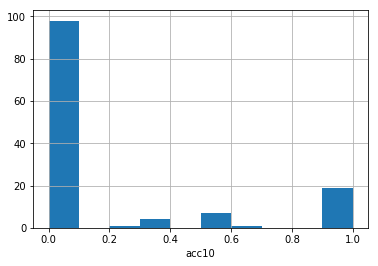

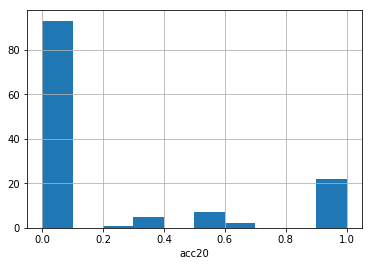

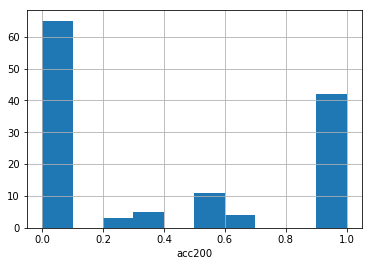

In [87]:
res = evaluate(best, gold)

In [142]:
send_email(notebook_url, body='Finished')

Successfully sent email


TODO:
* normalize = False in tfidf
* first 2-3 sents of query

# Check

In [141]:
txt = open(all_docs[826996], 'r').read()
sents = nltk.sent_tokenize(txt)
sents[:3]

['способ антитеррористический сверхскоростной межмегаполисный перевозка пассажир и груз  .',
 'способ антитеррористический сверхскоростной межмегаполисный перевозка пассажир и груз , включать железнодорожный сообщение в подземный туннель прямоугольный форма неглубокий заложение , выполнять в открытый траншея , рельс , сваривать в торец , укладывать на днище туннель с амортизировать лента , обеспечивать вибро и звукоизоляционный защита , перемещать по рельс туннель на бесшумный колесо поезд-челнок с электропривод , вагон с высокий уровень комфорт и безопасность выполнять из несгорать материал , отличать тем , что : - поезд-челнок делать только для обслуживание пассажиро- и грузопоток между мегаполиса , - поезд-челнок без остановка передвигаться между конечный вокзал мегаполис со скорость 300-350 км/ч , - обеспечивать практически прямолинейный путь движение поезда-челнока , - предусматривать одновременный движение в один туннель несколько поездов-челноков на безопасный расстояние , - на 

In [142]:
!cat {all_docs[826996]}

способ антитеррористический сверхскоростной межмегаполисный перевозка пассажир и груз  . 
 способ антитеррористический сверхскоростной межмегаполисный перевозка пассажир и груз , включать железнодорожный сообщение в подземный туннель прямоугольный форма неглубокий заложение , выполнять в открытый траншея , рельс , сваривать в торец , укладывать на днище туннель с амортизировать лента , обеспечивать вибро и звукоизоляционный защита , перемещать по рельс туннель на бесшумный колесо поезд-челнок с электропривод , вагон с высокий уровень комфорт и безопасность выполнять из несгорать материал , отличать тем , что : - поезд-челнок делать только для обслуживание пассажиро- и грузопоток между мегаполиса , - поезд-челнок без остановка передвигаться между конечный вокзал мегаполис со скорость 300-350 км/ч , - обеспечивать практически прямолинейный путь движение поезда-челнока , - предусматривать одновременный движение в один туннель несколько поездов-челноков на безопасный расстояние , - на коне

In [39]:
! cat {val_docs[0]}

﻿способ экономия электроэнергия .
 изобретение относиться к проблема экономия электроэнергия , как один из весомый в программа борьба с глобальный потепление климат , и эффективный мочь быть применять , как это ни показаться неожиданный , в область кулинарный хозяйство .
 проблема с электроэнергия возникнуть сразу же после изобретение в 1879 г . гениальный томас альва эдисон электрический лампа накаливание .
 при ее запиток от использовать тогда источник постоянный ток , недопустимый большой быть потеря в линия передача на большой расстояние .
 проблема быть устранять в 1887 г . один из великий физик современность никола теслый , свой изобретение генератор переменный ток и высоковольтный трансформатор .
 дальнейший нововведение , как и этот , подстраиваться , в основной , к электрический характеристика объект запиток , как правило не учитывать они физический особенность .
 в кулинария экономия затрачивать энергия не являться главенствующий фактор , но неизменный оставаться только стрем

In [23]:
val_docs[0]

'../data/validate/_01_98_2010120931A10010101RU.txt'

In [24]:
tweights['_01_98_2010120931A10010101RU']

,word,score
0,показаться,0.440496
1,весомый,0.398666
2,потепление,0.371143
3,климат,0.290792
4,неожиданный,0.246081
5,кулинарный,0.239139
6,возникнуть,0.237528
7,глобальный,0.233594
8,борьба,0.219673
9,экономия,0.197734


In [145]:
with open(all_docs[826996]) as f:
    text = f.read()
doc = []
for sent in nltk.sent_tokenize(text):
    doc.append(list(tokenize(sent)))

In [147]:
# doc = docs[4]
doc = doc[:3]
words = set([w for s in doc for w in s if w in wv])
# words = set([w for w in doc if w in wv])

smat = sim_matrix(words, val_words, wv)

query = tweights['_01_98_2010120931A10010101RU']
qsmat = smat.loc[:, query.word]
dist = wmd(qsmat, query.score)
dist


1.4902942601572982

In [148]:
qsmat

,показаться,весомый,потепление,климат,неожиданный,кулинарный,возникнуть,глобальный,борьба,экономия,электроэнергия,хозяйство,программа,проблема,область
груз,0.169204,0.246345,0.134826,0.151661,0.145275,0.126866,0.264887,0.173469,0.155164,0.245130,0.286394,0.198369,0.217770,0.196851,0.156944
неглубокий,0.294169,0.188261,0.186303,0.291177,0.182622,0.100001,0.334387,0.141134,0.219956,0.252299,0.201028,0.119175,0.118009,0.284169,0.304222
перрон,0.230164,0.178828,0.119399,0.184676,0.207974,0.074953,0.199838,0.184000,0.153047,0.169200,0.093440,0.168930,0.145796,0.163177,0.166470
торец,0.285827,0.181317,0.090059,0.128457,0.166120,0.100676,0.281818,0.118377,0.113302,0.206050,0.222287,0.162785,0.148492,0.251847,0.208813
межмегаполисный,0.223787,0.360315,0.269516,0.262507,0.274714,0.175211,0.460716,0.332023,0.293126,0.351048,0.318761,0.246493,0.282403,0.426892,0.237959
воздушный,0.204148,0.317586,0.250676,0.341972,0.188146,0.129827,0.287205,0.157454,0.191236,0.260126,0.319431,0.175214,0.152491,0.227233,0.172581
заложение,0.168508,0.202350,0.152061,0.326524,0.079525,0.127819,0.201326,0.188037,0.171726,0.244733,0.215021,0.208763,0.147233,0.180237,0.105036
защита,0.107125,0.161873,0.146659,0.240674,0.266580,0.128532,0.265806,0.162902,0.498945,0.201038,0.246533,0.304198,0.202161,0.320850,0.206886
мегаполиса,0.159522,0.345562,0.278665,0.308780,0.202876,0.144220,0.341637,0.322533,0.248693,0.295432,0.320618,0.305575,0.163811,0.300533,0.233478
прозрачный,0.200873,0.087647,0.076744,0.151058,0.145242,0.124079,0.132830,0.059046,0.047313,0.156787,0.123294,0.067669,0.043017,0.131139,0.153262


In [126]:
qsmat['кулинарный'].argmax()

'корень'

In [149]:
maxs = np.amax(qsmat, axis=0)
maxs.sort_values(ascending=False)
# np.dot(maxs, tfidf_weights)

область           1.000000
борьба            0.498945
возникнуть        0.478772
неожиданный       0.456684
экономия          0.442393
показаться        0.429655
проблема          0.429388
электроэнергия    0.420193
климат            0.419827
весомый           0.409968
хозяйство         0.372165
потепление        0.367603
глобальный        0.332023
программа         0.319816
кулинарный        0.296931
dtype: float32

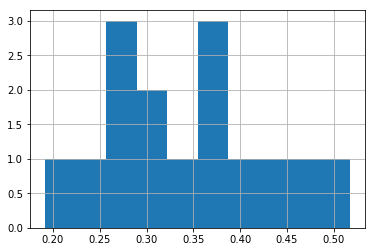

count    15.000000
mean      0.340660
std       0.088724
min       0.192080
25%       0.266790
50%       0.336685
75%       0.396482
max       0.517019
dtype: float64


In [62]:
maxs.hist()
plt.show()
print(maxs.describe())

**Чем больше документ, тем больше вероятность что в нем найдутся близкие слова к запросу**

Как с этим бороться:

* взять первых несколько (top 3) предложений в запросе и документе, взять, так сказать, суть
* привести все документы к одинаковому количеству слов. Можно взять топ 15 слов по tfidf из запроса и документа.
* взять первые 4 предложение и самое первое (название, обычно дублируется), выкинуть
* редкие слова (неучтенные стоп слова), которые не имеют особого значения, могут иметь большой вес tfidf, что обманывает алгоритм. Надо либо убрать как можно больше стоп слов, либо при подсчете расстояния м/у документами не учитывать tfidf вообще
* чтобы исключить стоп слова или другой мусор, можно взять параметр tfidf модели - процент встречи > 50% то считаем шумом
* поиграть с параметрами - для запроса первые 3 предложения, для документа - 3,4,5


# First_n

In [11]:
fn = join(DATA_FOLDER, 'first3_val.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
val_documents = json.loads(text)
del text

In [12]:
tweights = {}
for fname, doc in tqdm(zip(val_docs, val_documents)):
    tokenized_filtered = [w for w in doc if w in wv]
    doc_bow = dictionary.doc2bow(tokenized_filtered)
    sorted_tfidf = sorted(tfidf[doc_bow], key=itemgetter(1), reverse=True)
    sorted_tfidf = pd.DataFrame([(dictionary[k],v) for k,v in sorted_tfidf],
                               columns=['word', 'score'])

    name = path.splitext(basename(fname))[0]
    tweights[name] = sorted_tfidf

val_words = set(pd.concat([v.word for v in tweights.values()]))

130it [00:00, 1588.17it/s]


In [13]:
fn = join(DATA_FOLDER, 'first3.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
docs = json.loads(text)
del text

In [14]:
doc_dists = []

split_on = len(docs)//(cpu_count*100)
for i,sub_docs in enumerate(tqdm(np.array_split(docs, split_on))):
    ! echo {i} >> ../data/out
    parallelizer = Parallel(n_jobs=cpu_count)

    # this iterator returns the functions to execute for each task
    tasks_iterator = ( delayed(_calc)(docs_block) for 
                      docs_block in grouper(100, sub_docs) )  
    result = parallelizer( tasks_iterator )        
    doc_dists += result

# doc_dists = _calc(docs)

val_dists = np.array(sum(doc_dists, []))

100%|██████████| 2/2 [00:14<00:00,  9.13s/it]


In [47]:
val_dists[:,0]

array([ 1.54428693,  1.01526538,  1.16861337,  1.18620118,  0.9272794 ,
        1.15697594,  1.17571529,  1.03664417,  1.18212488,  1.05627956])

In [17]:
sorted_args = val_dists.argsort(axis=0)[-20000000:][::-1]

In [21]:
sorted_args[:,0]

array([0, 3, 8, 6, 2, 5, 9, 7, 1, 4])

In [ ]:
np.save(join(DATA_FOLDER, 'val_dists_first3.npy'), val_dists)

In [150]:
sorted_args = np.load(join(DATA_FOLDER, 'sorted_args_first3_200.npy'))

In [151]:
sorted_args

array([[1022450, 1022450, 1022450, ..., 1022450, 1022450, 1022450],
       [ 842926,  756153, 1036047, ...,  696622, 1140775,  726681],
       [ 861782,  650141,  850739, ...,  896596,  492756,  399365],
       ..., 
       [ 886947, 1177928, 1042075, ...,  674707,  949645,  719583],
       [ 776729, 1063726,  840002, ..., 1060504,  280419,  896097],
       [1043274, 1159591,  854615, ...,  867012,  576818,  970921]])

In [152]:
best = {}
for i in range(sorted_args.shape[1]):
    col = sorted_args[:,i]
    name = path.splitext(basename(val_docs[i]))[0]
    top = []
    for j,c in enumerate(col):
        top.append(path.splitext(basename(all_docs[c]))[0])
    best[name] = top

In [153]:
with open(join(DATA_FOLDER, 'gold.json'), 'r') as f:
    gold = json.load(f)

median
acc10     0.0
acc20     0.0
acc200    0.0
dtype: float64
mean
acc10     0.124359
acc20     0.192308
acc200    0.379487
dtype: float64


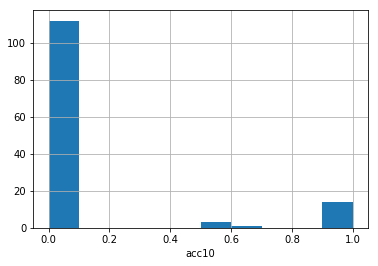

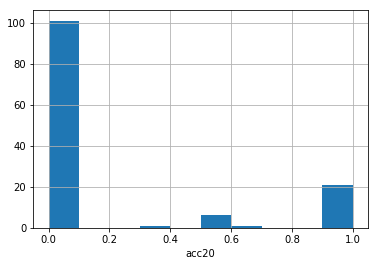

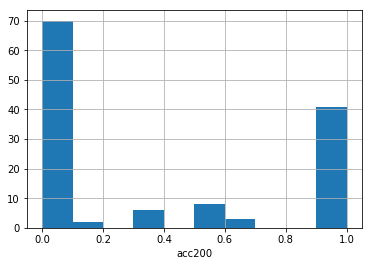

In [154]:
res = evaluate(best, gold)